### Regression Analysis with World Bank Data

The objective of this exercise is to fit a basic model to evaluate the relationship between various economic indicators and average life expectancy by country in a specific year. The explanatory variables are GDP per capita, the percentage of health expenditure, access to drinking water, access to sanitation services, and the literacy rate. Although many other relevant explanatory variables exist, these were chosen because they are recognized in the literature. The variable to be explained is life expectancy. 

This project follows the CRISP-DM process and includes:
- Exploratory analysis and detailed visualizations
- Data cleaning and preparation
- Model training
- Model evaluation with metrics and SHAP values
- Prediction for Colombia in 2018
ombia in 2018

In [63]:
# Paso 0: Install required packages
#!pip install pandas statsmodels matplotlib seaborn shap scikit-learn
import wbgapi as wb
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np
# 1. Library loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap

## Step 1: Data Exploration and Cleaning

Download the data from the World Bank. Each file contains data by country and year. We need to combine all the indicators into a single DataFrame.

In [71]:
# Load each indicator
life_expectancy = pd.read_csv(r"C:...\API_SP.DYN.LE00.IN_DS2_en_csv_v2_372213.csv", skiprows=4)
gdp_per_capita = pd.read_csv(r"C:\...\API_NY.GDP.PCAP.CD_DS2_en_csv_v2_375637.csv", skiprows=4)
health_expenditure = pd.read_csv(r"C:\...\API_SH.XPD.CHEX.PC.CD_DS2_en_csv_v2_87561.csv", skiprows=4)
literacy_rate = pd.read_csv(r"C:\...\API_SE.ADT.LITR.ZS_DS2_en_csv_v2_372790.csv", skiprows=4)
access_to_water = pd.read_csv(r"C:\...\API_SH.H2O.SMDW.ZS_DS2_en_csv_v2_375280.csv", skiprows=4)
access_to_sanitation = pd.read_csv(r"C:\...\API_SH.STA.SMSS.ZS_DS2_en_csv_v2_375324.csv", skiprows=4)

# Select the relevant columns (e.g. year 2020)
year = '2020'
indicators = [life_expectancy, gdp_per_capita, health_expenditure,
              literacy_rate, access_to_water, access_to_sanitation]
indicator_names = ['life_expectancy', 'gdp_per_capita', 'health_expenditure',
                   'literacy_rate', 'access_to_water', 'access_to_sanitation']

# Create a unified DataFrame
data = pd.DataFrame()
data['Country Name'] = life_expectancy['Country Name']
for df, name in zip(indicators, indicator_names):
    data[name] = df[year]

# Delete rows with missing values
data.dropna(inplace=True)

# Save the clean DataFrame
data.to_csv(r"C:\...\worldbank_life_expectancy_dataset.csv", index=False)

df = pd.read_csv(r"C:\...\worldbank_life_expectancy_dataset.csv")
df = df[df['Country Name'] != 'World']
df.head()

,Country Name,life_expectancy,gdp_per_capita,health_expenditure,literacy_rate,access_to_water,access_to_sanitation
0,Africa Western and Central,57.364425,1664.249176,64.407423,59.703239,28.810001,21.648996
1,Armenia,73.375610,4268.680933,535.272400,100.000000,82.685819,10.829497
2,Bangladesh,71.421000,2248.850788,51.006241,75.000000,58.655998,29.028513
3,Central African Republic,50.596000,462.879071,42.634758,37.490002,6.183318,13.603806
4,Central Europe and the Baltics,76.007403,16450.877509,1180.703773,99.456596,91.512146,89.314017


### Descriptive Analysis and Distributions

In [73]:
# General information about the DataFrame
print("Dimensiones del DataFrame:", df.shape)
    
# Information about data types
print("\nTipos de datos:")
print(df.dtypes)
    
# Check for null values
print("\nValores nulos por columna:")
print(df.isnull().sum())

Dimensiones del DataFrame: (35, 7)

Tipos de datos:
Country Name             object
life_expectancy         float64
gdp_per_capita          float64
health_expenditure      float64
literacy_rate           float64
access_to_water         float64
access_to_sanitation    float64
dtype: object

Valores nulos por columna:
Country Name            0
life_expectancy         0
gdp_per_capita          0
health_expenditure      0
literacy_rate           0
access_to_water         0
access_to_sanitation    0
dtype: int64


We have 36 countries in the sample. There are no null values.

In [76]:
descriptivos = df.describe()
descriptivos

,life_expectancy,gdp_per_capita,health_expenditure,literacy_rate,access_to_water,access_to_sanitation
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,71.158735,10780.359300,1038.246612,86.399727,62.285095,51.332006
std,6.850682,15424.001099,2079.784196,15.467074,26.295626,26.552890
min,50.596000,462.879071,34.475401,37.490002,6.183318,10.829497
25%,66.664330,2126.847092,76.619137,75.440151,39.866419,24.869930
50%,72.720000,5365.472207,412.160941,94.313309,67.408010,48.228198
75%,75.113674,8642.166170,583.590014,97.589455,80.257645,66.087712
max,83.543902,62271.196915,11052.919631,100.000000,100.000000,100.000000


The global average life expectancy is 71 years, with a standard deviation of 6 years. The global average per capita GDP is 10,000 per month, with a standard deviation of 15,000, reflecting a high income distribution across countries. The average health expenditure is 1,000, with marked differences in distribution across countries. The global literacy rate averages 86%, and access to sanitation is 50%.


Generando visualizaciones...


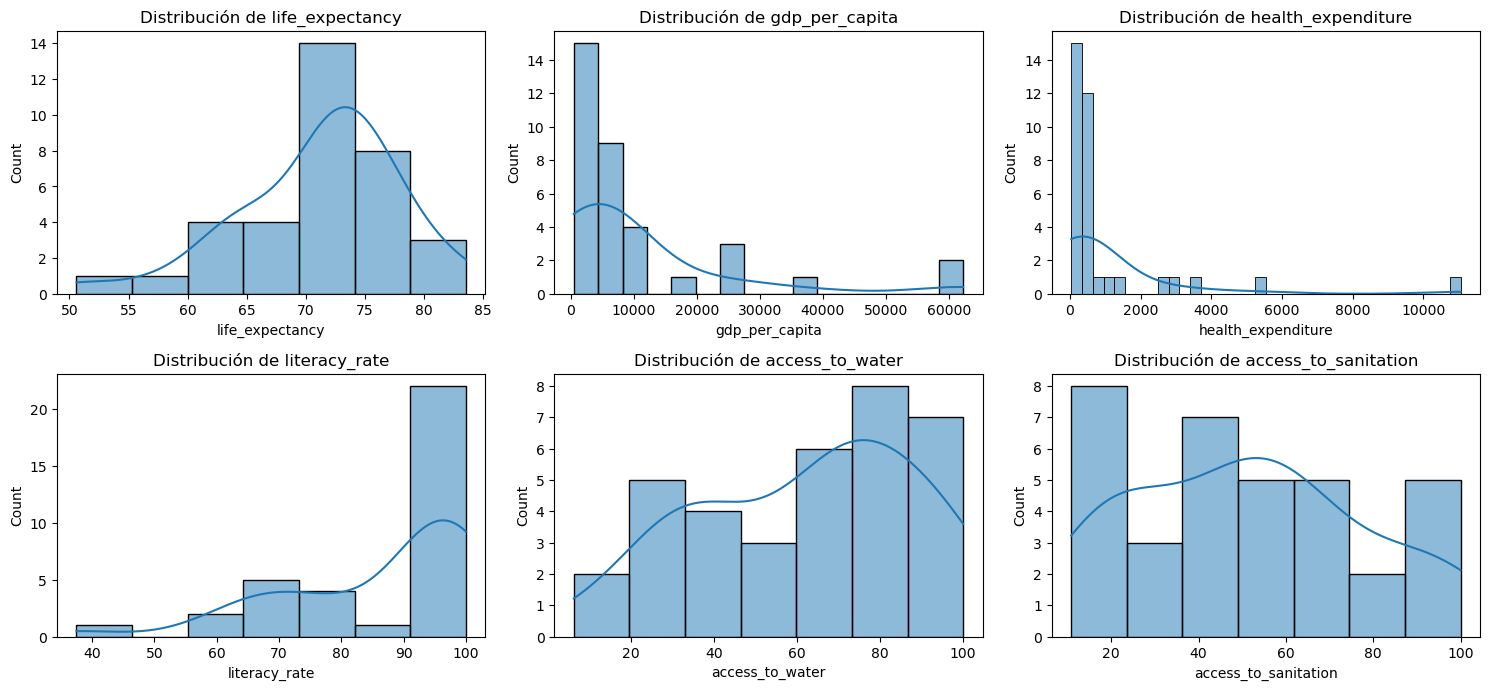

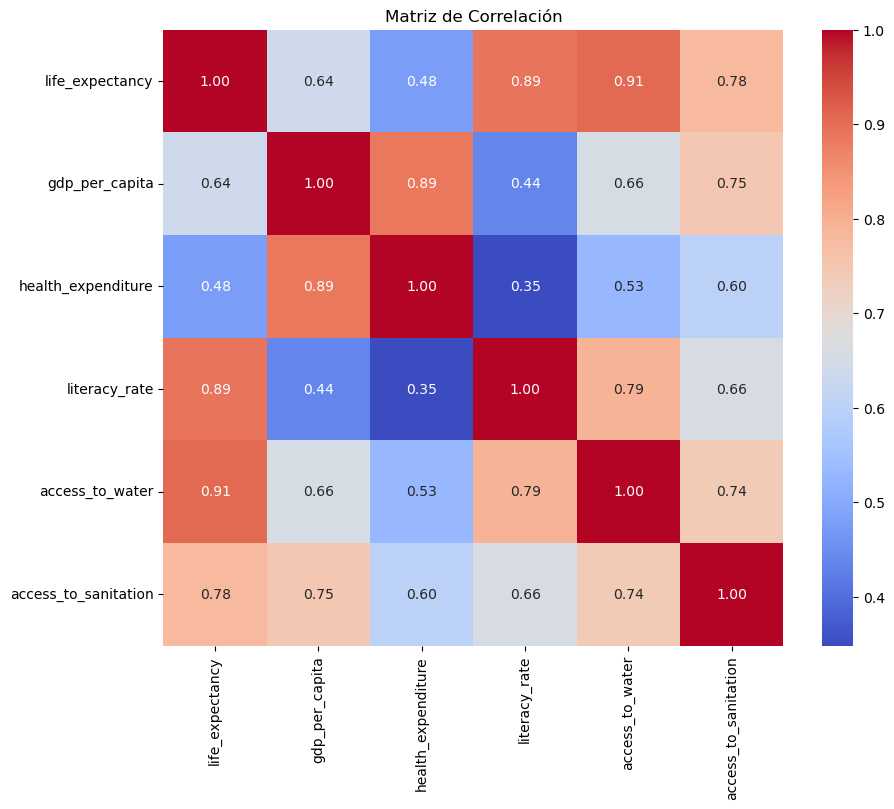

In [79]:
   
# Visualizing the distribution of numerical variables
print("\nGenerando visualizaciones...")
    
# Select only numeric columns for histograms
numeric_columns = df.select_dtypes(include=[np.number]).columns
if len(numeric_columns) > 0:
        plt.figure(figsize=(15, 10))
        for i, column in enumerate(numeric_columns[:min(9, len(numeric_columns))]):
            plt.subplot(3, 3, i+1)
            sns.histplot(df[column], kde=True)
            plt.title(f'Distribución de {column}')
        plt.tight_layout()
        plt.show()
    
# Correlation matrix for numerical variables
if len(numeric_columns) > 1:
        plt.figure(figsize=(10, 8))
        correlation_matrix = df[numeric_columns].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Matriz de Correlación')
        plt.show()

The skewed distribution of per capita GDP and health expenditures is verified. Given that our interest is in explaining average life expectancy, we find a high correlation between the explanatory variables and our variable of interest. We observe that the most correlated variable is access to water, followed by the literacy rate. Oddly, health expenditure has the lowest observed correlation. There are expectedly high correlations between per capita GDP and health expenditure and access to healthcare.

<Figure size 1200x1000 with 0 Axes>

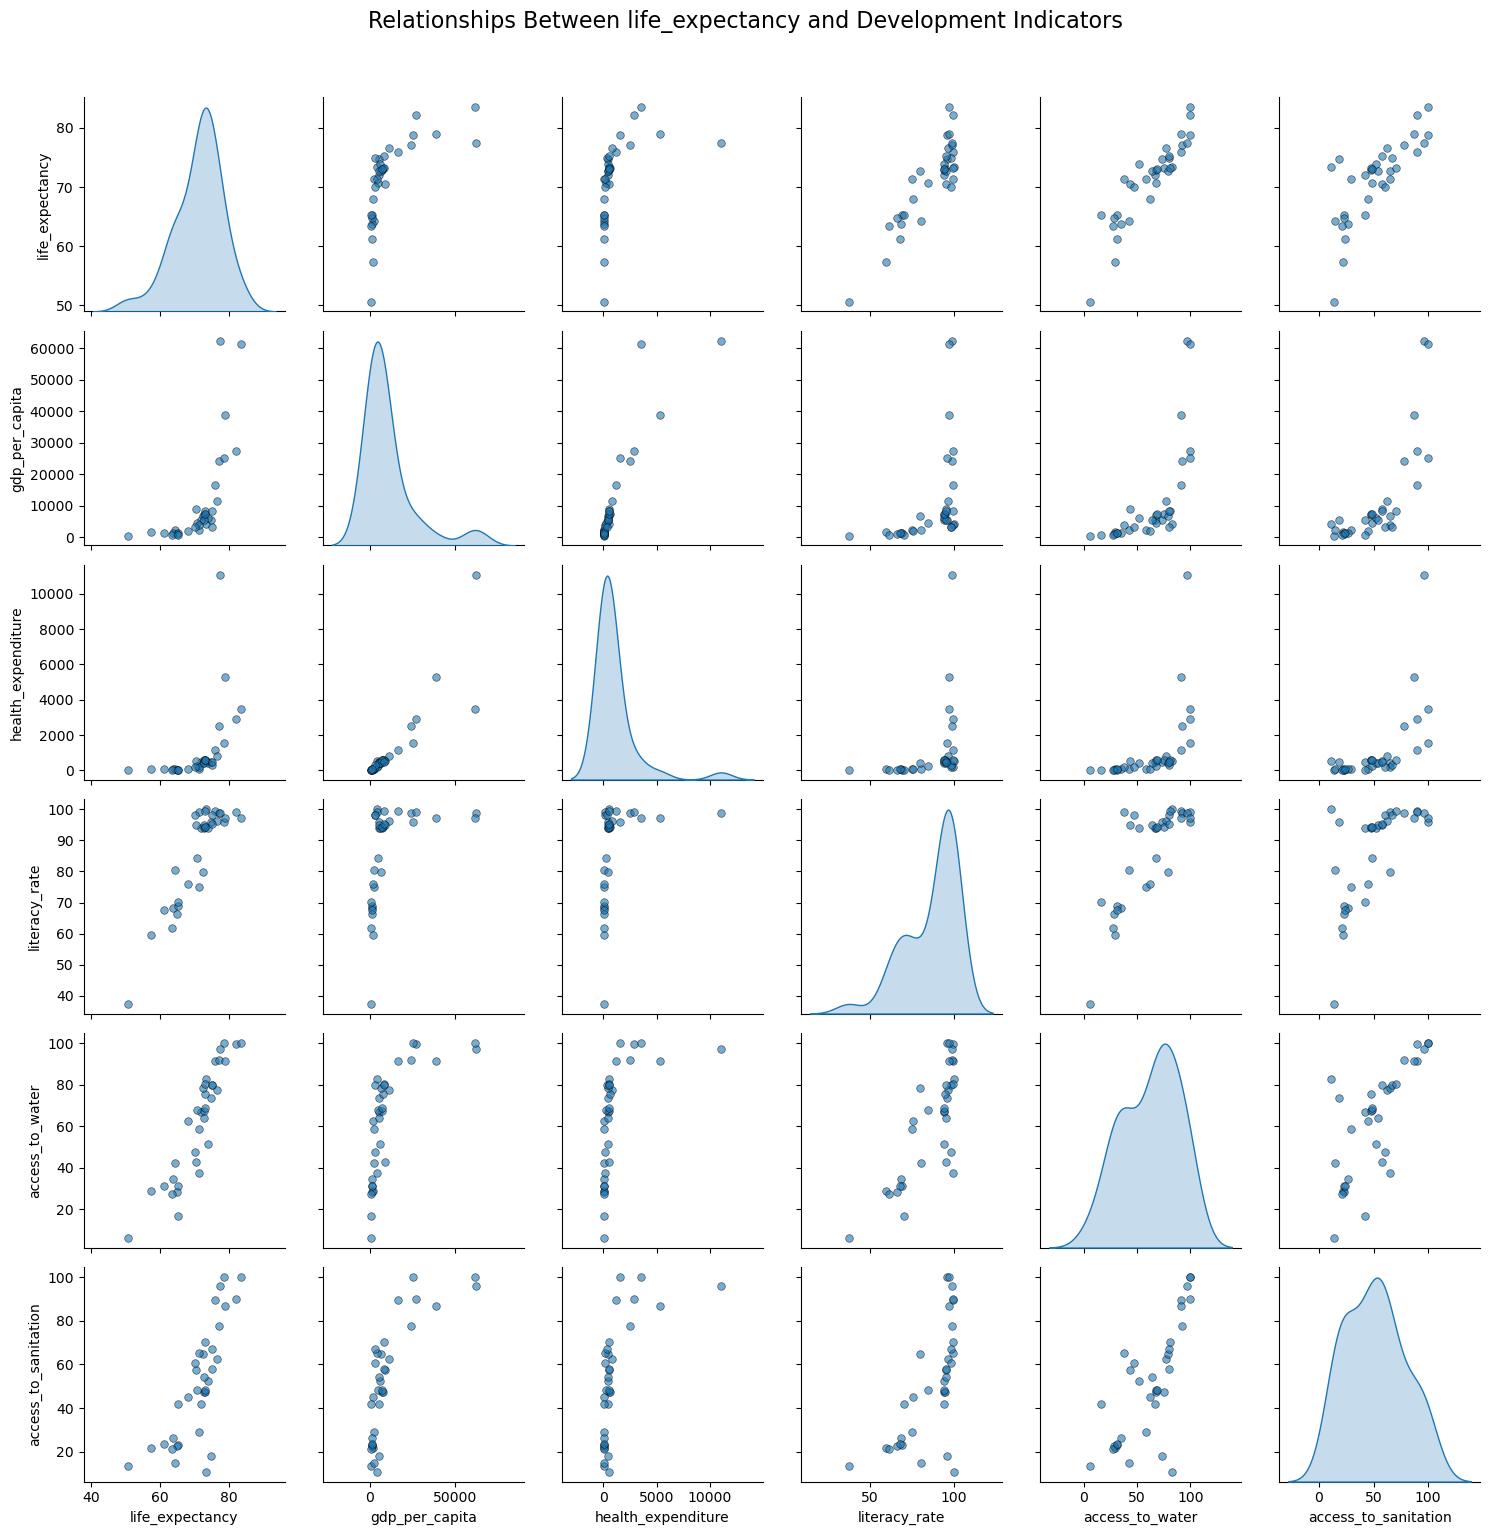

In [81]:
# Create the pair plot
plt.figure(figsize=(12, 10))
pair_plot = sns.pairplot(
    df,
    vars=['life_expectancy', 'gdp_per_capita', 'health_expenditure', 
          'literacy_rate', 'access_to_water', 'access_to_sanitation'],
    diag_kind='kde',
    plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'k', 'linewidth': 0.5}
)

# Set title
pair_plot.fig.suptitle('Relationships Between life_expectancy and Development Indicators', y=1.02, fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()

The graph shows the relationship between the variables. A seemingly positive linear relationship is evident between all our explanatory variables and our response variable, which is what we intuitively expect. It strangely confirms that health spending appears to have no obvious relationship with the other variables or with life expectancy.

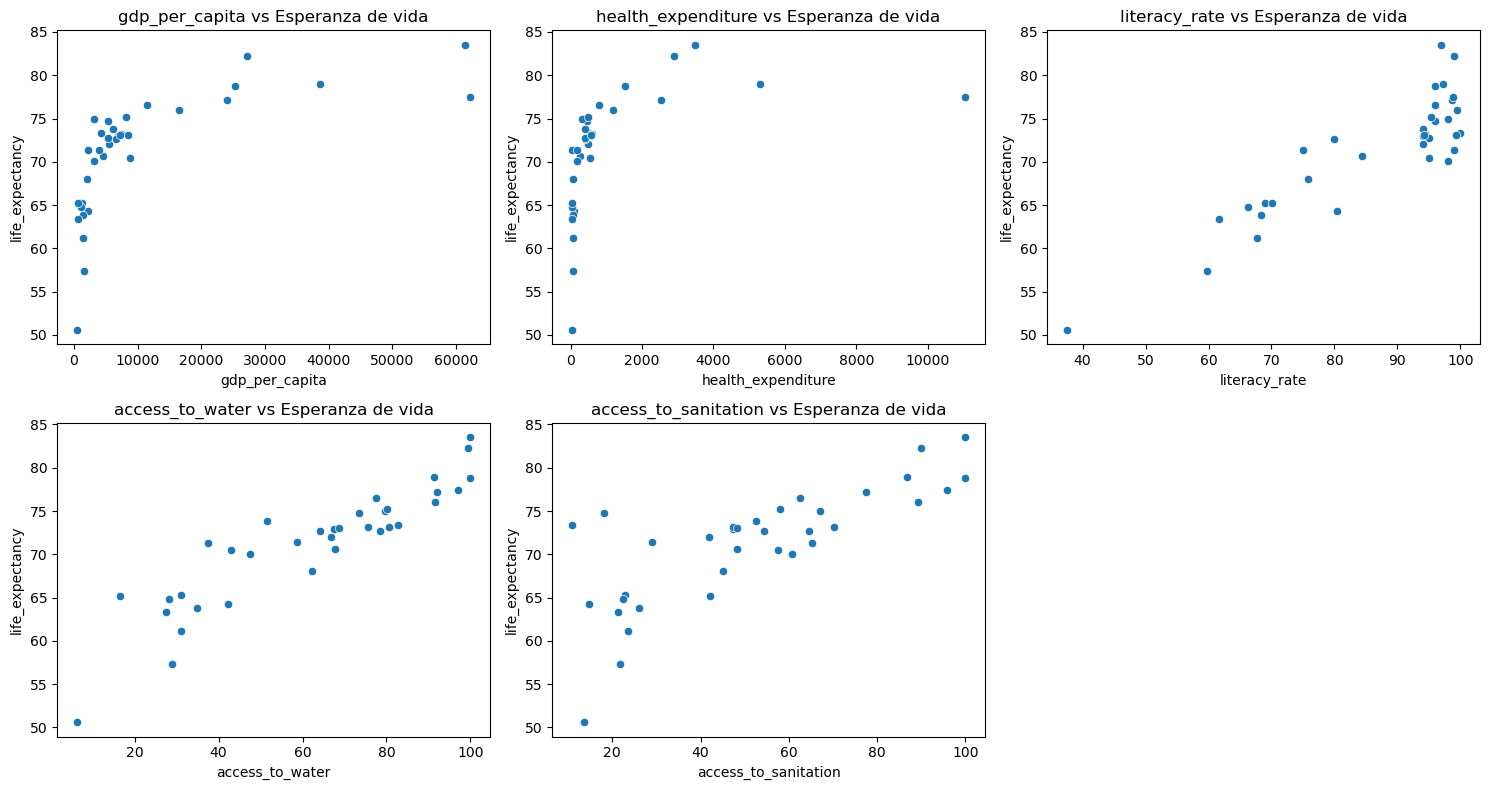

In [83]:
# Filtrar solo columnas numéricas
import math
numericas = df.select_dtypes(include='number')

# Excluir la columna 'esperanza de vida' del conjunto de variables independientes
features = numericas.drop(columns=['life_expectancy'], errors='ignore').columns

# Calcular dimensiones de la grilla de subplots
n = len(features)
n_cols = 3  # número de columnas que quieres en la grilla
n_rows = math.ceil(n / n_cols)

# Crear figura y ejes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()  # Para poder indexar fácilmente

# Crear los scatterplots
for i, feature in enumerate(features):
    sns.scatterplot(data=df, x=feature, y='life_expectancy', ax=axes[i])
    axes[i].set_title(f'{feature} vs Esperanza de vida')

# Eliminar subplots vacíos si los hay
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar espaciado
plt.tight_layout()
plt.show()

Let's take a closer look at the relationship between our exponential variables and our response variable. There is an apparent strong positive linear relationship between access to water and literacy rates, access to sanitation, and life expectancy. GDP per capita does not show such a strong relationship, perhaps obscured by the presence of outliers and a highly skewed distribution.

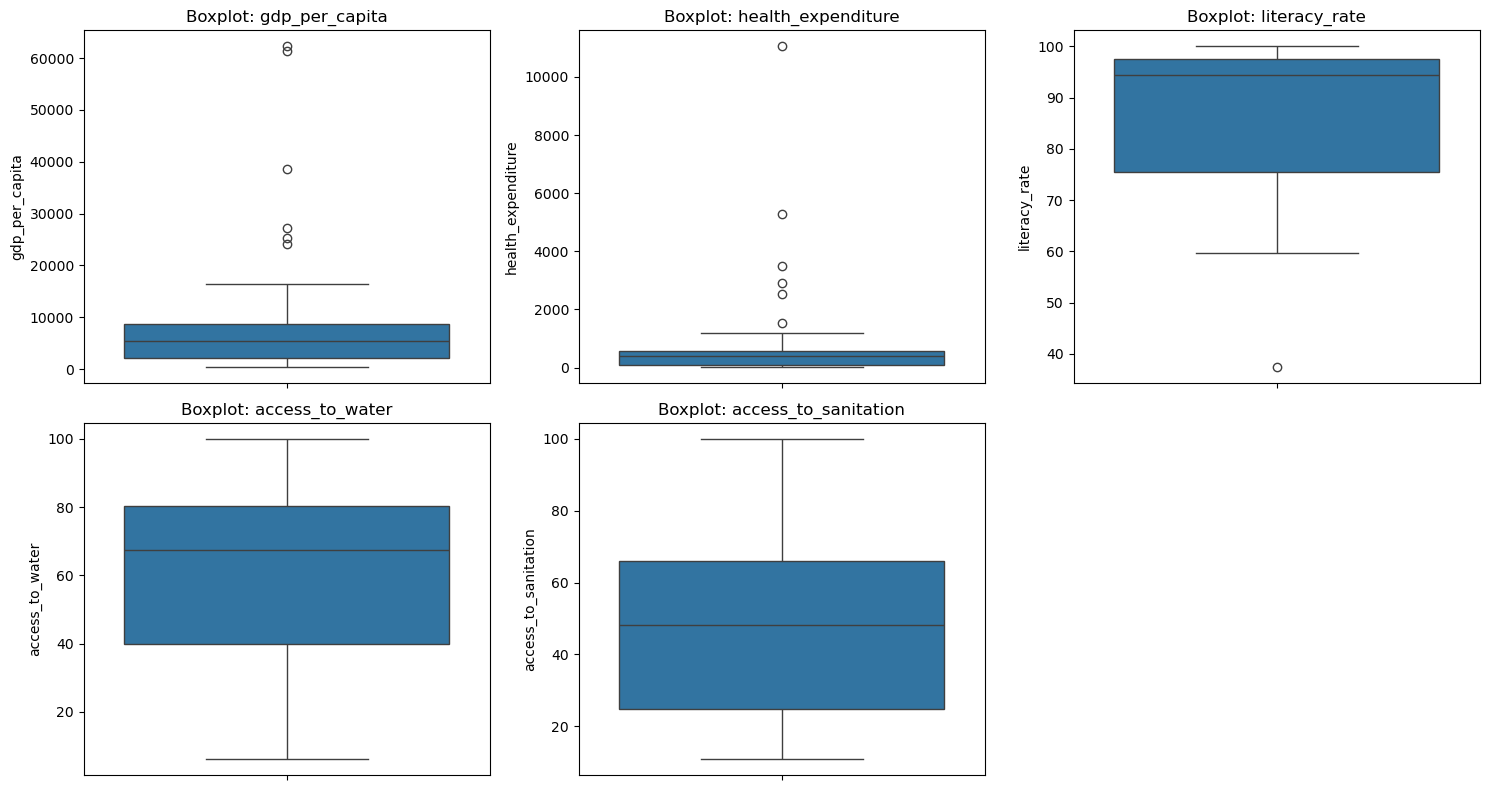

In [85]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

# boxplots
for i, feature in enumerate(features):
    sns.boxplot(y=df[feature], ax=axes[i])
    axes[i].set_title(f'Boxplot: {feature}')

# Eliminar subgráficos vacíos si sobran
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The box plots confirm the skewed distributions of GDP per capita and health spending. There are many countries with low GDP per capita and low health spending compared to rich countries with high spending. On the contrary, it appears that most countries have achieved high literacy rates.

## Step 2: Model Training

We build training and test samples (Caution!: our base is very small so the samples might not be adequate. We do this only for illustrative purposes for this toy exercise). We decided to use a tree model because it's a recognizedly efficient algorithm. In a real-world exercise, we would need to tune several algorithms and compare their performance.

In [90]:
# 5. Models
X = df.drop(columns=['life_expectancy', 'Country Name'])
y = df['life_expectancy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Paso 3: Evaluación del Modelo y Explicabilidad con SHAP

MAE: 1.7406695335499214
RMSE: 2.1518793576287707
R2: 0.4571180251001825


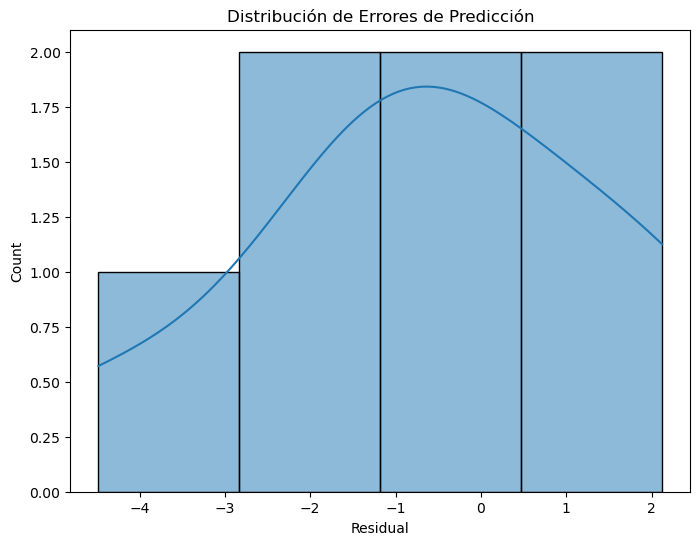

In [92]:
print('MAE:', mean_absolute_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

residuals = y_test - y_pred
plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True)
plt.title("Distribución de Errores de Predicción")
plt.xlabel("Residual")
plt.show()

We calculate the standard model fit metrics. The R^2 is 0.45, implying that the model explains 45% of the variability in our target variable. The RMSE is 2.1, implying that our model deviates approximately 2.1 years from the true value of life expectancy. And the absolute difference is 1.7 years. A pretty decent model for a toy exercise!

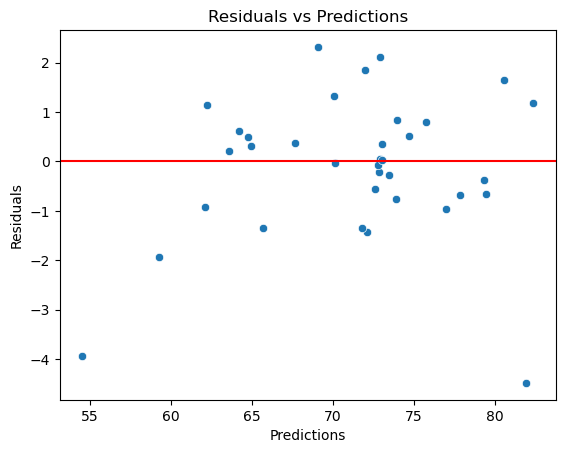

In [94]:
# Residuales
y_pred = model.predict(X)
residuals = y - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals vs Predictions')
plt.show()

Despite adequate global metrics, it is necessary to examine the performance in specific cases. We observe (1) no observable pattern or bias in the residuals, which is good, but (2) there appear to be some poorly fitted points. These are detailed below:

                  Country Name  life_expectancy  prediction  residual
24               North America        77.449874   81.931990 -4.482116
3     Central African Republic        50.596000   54.532089 -3.936089
2                   Bangladesh        71.421000   69.102554  2.318446
29          West Bank and Gaza        74.998000   72.874030  2.123970
0   Africa Western and Central        57.364425   59.293251 -1.928826
26                        Peru        73.832000   71.986964  1.845036
9                        Spain        82.231707   80.581102  1.650606
19         Low & middle income        70.667411   72.102075 -1.434664
21                      Mexico        70.449000   71.801357 -1.352357
10                       Ghana        64.309000   65.651868 -1.342868


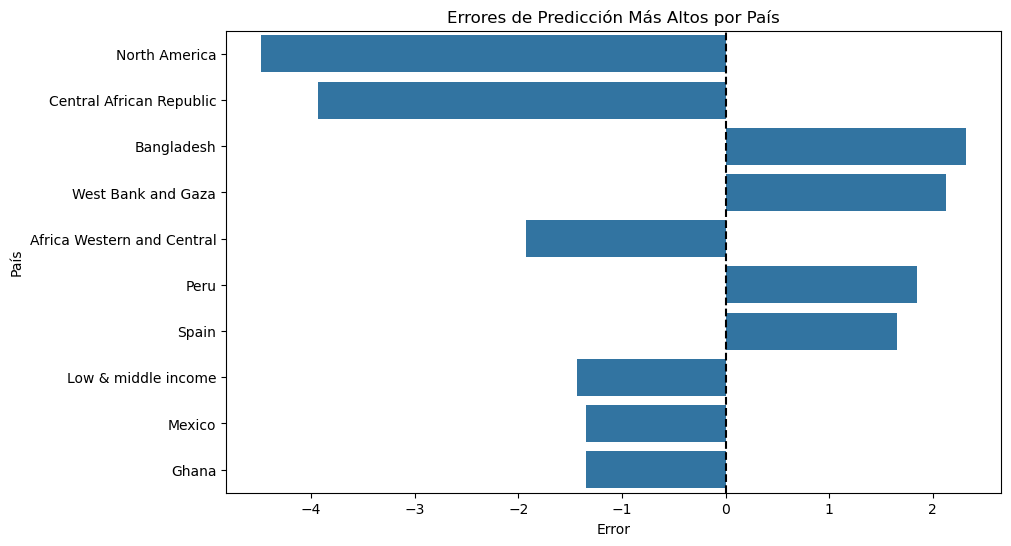

In [96]:
# 8. Análisis de Errores por País
df['prediction'] = model.predict(X)
df['residual'] = df['life_expectancy'] - df['prediction']
df['abs_residual'] = df['residual'].abs()
top_errors = df.sort_values('abs_residual', ascending=False).head(10)
print(top_errors[['Country Name', 'life_expectancy', 'prediction', 'residual']])

plt.figure(figsize=(10,6))
sns.barplot(data=top_errors, x='residual', y='Country Name')
plt.axvline(0, color='black', linestyle='--')
plt.title("Errores de Predicción Más Altos por País")
plt.xlabel("Error")
plt.ylabel("País")
plt.show()

Tenemos sobreestimaciones para Bangladesh, Gaza, Perú y Spain y subestimaciones para México, Ghana y Africa Western and Central

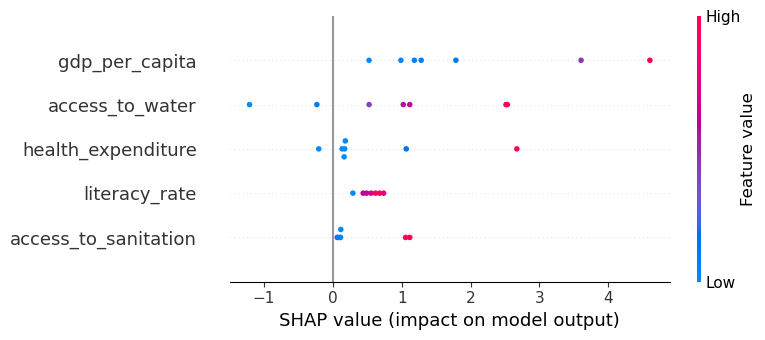

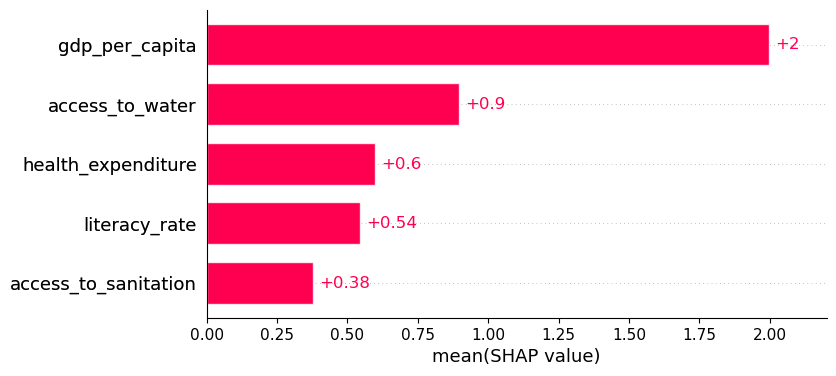

In [98]:
# 7. Interpretabilidad con SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)
shap.plots.bar(shap_values.mean(0))

To better understand how the model generates its predictions, we applied SHAP (SHapley Additive exPlanations), a method that quantifies the contribution of each input variable to the model’s output. The results reveal the following:

1. The most influential variable in the model’s predictions is GDP per capita (gdp_per_capita).

This feature has the highest average impact and shows a clear directional trend:
countries with higher GDP per capita tend to receive higher predicted values, while those with lower GDP per capita are associated with lower predictions.



2. Access to water (access_to_water) is also a significant driver of the model’s decisions.

High access to water is generally associated with increased predictions, aligning with its expected relationship to socioeconomic development.



3. Other features such as health expenditure, literacy rate, and access to sanitation have a smaller average impact on the model’s output.


4. Overall, the model appears to associate better social and economic indicators with higher predicted values, which may reflect an underlying construct such as development, well-being, or performance.

## Step 4: Prediction for a specific scenario (Colombia 2018)


Let's use the model to forecast another year in the sample.

In [102]:
year = '2018'
indicators = [life_expectancy, gdp_per_capita, health_expenditure,
              literacy_rate, access_to_water, access_to_sanitation]
indicator_names = ['life_expectancy', 'gdp_per_capita', 'health_expenditure',
                   'literacy_rate', 'access_to_water', 'access_to_sanitation']
data_2018 = pd.DataFrame()
data_2018['Country Name'] = life_expectancy['Country Name']
for df, name in zip(indicators, indicator_names):
    data_2018[name] = df[year]
data_2018.dropna(inplace=True)

In [103]:
sample = data_2018[(data_2018['Country Name'] == 'Colombia')]
sample_X = sample[['gdp_per_capita', 'health_expenditure', 'literacy_rate', 'access_to_water', 'access_to_sanitation']]
pred = model.predict(sample_X)
print(f"Estimated life expectancy for Colombia in 2018: {pred[0]:.2f} years")
print(f"Real life expectancy for Colombia in 2018: {sample['life_expectancy'].values[0]:.2f} years")

Estimated life expectancy for Colombia in 2018: 73.43 years
Real life expectancy for Colombia in 2018: 76.58 years


## Recomendations

Despite being a toy exercise, the results are not that bad !!!. However, the data structure with individual and time dimensions would be better modeled with panel data models. This would also increase the available training population. Likewise, more explanatory variables need to be considered.